In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost.sklearn import XGBClassifier
#import matplotlib.pyplot as plt
from dateutil.parser import parse
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from utils import userDevice, handleUrl, encode
from constants_new import *
import matplotlib.pylab as plt

In [2]:
%run constants_new

In [3]:
train = pd.read_csv(TRAIN_PATH, sep='\t', names=COL_NAMES)

In [5]:
oh_cols = pd.DataFrame()
for k,v in COL_ENCODE_VOCABULARY.items():
    cols_name_oh = pd.get_dummies(v).rename(lambda x: k +'_'+ str(v[x])).T
    k_oh = cols_name_oh.loc[train[k]]
    k_oh.reset_index(inplace=True)
    # reset_index后会自动加一个index,以保存原始的列index
    # 避免settingwithcopyWarning
    k_oh = k_oh.drop('index', axis=1)
    oh_cols = pd.concat([oh_cols,k_oh], axis=1)

In [6]:
train = pd.concat([train[RE_INEX_NAME],oh_cols],axis =1)

In [7]:
train.head(1)

,click_clock,label,room_num,hall_num,toilet_num,pro_area,pro_price,pro_floor,floor_num,in_flag,...,decorate_like_oh_0,decorate_like_oh_1,decorate_like_oh_2,decorate_like_oh_3,decorate_like_oh_4,decorate_like_oh_5,decorate_like_oh_6,rent_type_like_oh_-1,rent_type_like_oh_0,rent_type_like_oh_1
0,16,0,3,2,2,19,1900,9,12,-1,...,0,0,0,1,0,0,0,0,1,0


In [8]:
xgb = XGBClassifier(**PARAMS)
predictors = [x for x in train.columns if x not in ['guid', 'pro_id', 'cs_time', 'label']]
xgb.fit(train[predictors], train['label'], eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.3, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)

In [9]:
test = pd.read_csv(TEST_PATH, sep='\t', names=COL_NAMES)
test['pro_history_clicks'] -= test['today_pro_clicks']
test['user_history_clicks'] -= test['today_user_clicks']
oh_cols = pd.DataFrame()
for k,v in COL_ENCODE_VOCABULARY.items():
    cols_name_oh = pd.get_dummies(v).rename(lambda x: k +'_'+ str(v[x])).T
    k_oh = cols_name_oh.loc[test[k]]
    k_oh.reset_index(inplace=True)
    # reset_index后会自动加一个index,以保存原始的列index
    # 避免settingwithcopyWarning
    k_oh = k_oh.drop('index', axis=1)
    oh_cols = pd.concat([oh_cols,k_oh], axis=1)
test = pd.concat([test[RE_INEX_NAME],oh_cols],axis =1)

AUC Score (Test): 0.797140
Logloss Score (Test): 0.181989


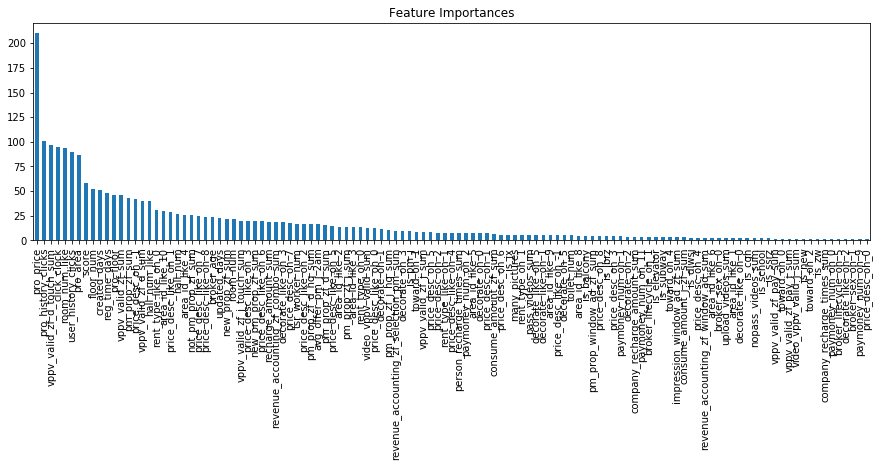

In [10]:
test['predprob'] = xgb.predict_proba(test[predictors])[:, 1]

print('AUC Score (Test): %f' % metrics.roc_auc_score(test['label'], test['predprob']))
print('Logloss Score (Test): %f' % metrics.log_loss(test['label'], test['predprob']))

plt.figure(figsize=(15,4))
feat_imp = pd.Series(xgb.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.show()

In [21]:
test['predprob']

0         0.064846
1         0.064846
2         0.075638
3         0.075638
4         0.029224
5         0.029224
6         0.010615
7         0.053551
8         0.120428
9         0.015821
10        0.110778
11        0.065562
12        0.075094
13        0.075094
14        0.075094
15        0.061720
16        0.131483
17        0.113618
18        0.113618
19        0.075647
20        0.075647
21        0.061720
22        0.102876
23        0.102876
24        0.093599
25        0.103879
26        0.102876
27        0.040917
28        0.040917
29        0.000383
            ...   
399241    0.006208
399242    0.009370
399243    0.009370
399244    0.034895
399245    0.034895
399246    0.000286
399247    0.000278
399248    0.010215
399249    0.010338
399250    0.000286
399251    0.078750
399252    0.010215
399253    0.022176
399254    0.000278
399255    0.036505
399256    0.023980
399257    0.075306
399258    0.000327
399259    0.098348
399260    0.075306
399261    0.075306
399262    0.

In [11]:
len(RE_INEX_NAME)

92

In [12]:
train.dtypes

click_clock             int64
label                   int64
room_num                int64
hall_num                int64
toilet_num              int64
pro_area                int64
pro_price               int64
pro_floor               int64
floor_num               int64
in_flag                 int64
pro_type                int64
created_days            int64
updated_days            int64
many_pictures           int64
favorites_cnt           int64
pro_history_clicks      int64
is_jx                   int64
is_first                int64
is_balcony              int64
is_elevator             int64
is_new                  int64
is_park                 int64
is_lbrz                 int64
is_jdqq                 int64
is_mfzj                 int64
is_ssrz                 int64
is_cgh                  int64
is_qxzx                 int64
is_qzqp                 int64
is_dlwsj                int64
                        ...  
price_desc_like_oh_2    uint8
price_desc_like_oh_3    uint8
price_desc

In [23]:
train.head(256).to_csv('/Users/huzuoliang/train.csv')

In [22]:
train.shape

(330474, 191)

In [24]:
feat_imp

pro_price                              210
pro_history_clicks                     101
vppv_valid_zf_d_touch_sum               97
click_clock                             95
room_num_like                           94
user_history_clicks                     90
pro_area                                87
score                                   58
floor_num                               52
created_days                            51
reg_time_days                           48
pro_floor                               46
vppv_valid_zf_sum                       46
pm_prop_zf_sum                          43
price_desc_oh_-1                        42
vppv_valid_zf_d_sum                     40
hall_num_like                           40
rent_type_like_oh_0                     31
area_id_like_10                         30
price_desc_like_oh_1                    29
hall_num                                27
area_id_like_4                          26
not_pm_prop_zf_sum                      26
price_desc_